# Set up

In [110]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
%cd "/content/drive/MyDrive/Projects/MNIST"

/content/drive/MyDrive/Projects/MNIST


In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
import requests
from io import BytesIO
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import datasets

In [113]:
TRAIN_CSV = "train.csv"
TEST_CSV = "test.csv"

In [114]:
class DataImporter:
  """
  Imports the training and test datasets
  """

  def __init__(self, train, test):
    self.train_path = train
    self.test_path = test
    self.__df_train = None
    self.__df_test = None

  def __import_data(self):
    """
    Imports the datasets and fields
    """
    self.__df_train = pd.read_csv(self.train_path)
    self.__df_test = pd.read_csv(self.test_path)
    return self

  def get_data(self):
    """
    Imports and returns the data
    """
    self.__import_data()
    return self.__df_train, self.__df_test

Let's import our datasets!

In [115]:
data_importer = DataImporter(TRAIN_CSV, TEST_CSV)

In [116]:
df_train, df_test = data_importer.get_data()

In [117]:
df_train.shape, df_test.shape

((42000, 785), (28000, 784))

In [118]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Explore datasets

In [120]:
class ImageViewer:
  """
  Provides utilities to view images
  """
  def __init__(self, df, target):
    self.y = df[target]
    self.X = df.iloc[:, 1:]

  def view(self, index):
    """
    Plots a selected image from the df
    """
    # get image and label from dataset
    image = self.X.iloc[index, :]
    label = self.y[index]
    # reshape image into matrix
    image = image.to_numpy().reshape((28, 28))
    # plot image
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.title(f"Label: {label}")
    plt.show()

  def view_random(self):
    """
    Plots a random image from the df
    """
    idx = np.random.randint(0, len(self.X))
    self.view(idx)

In [121]:
imv = ImageViewer(df_train, "label")

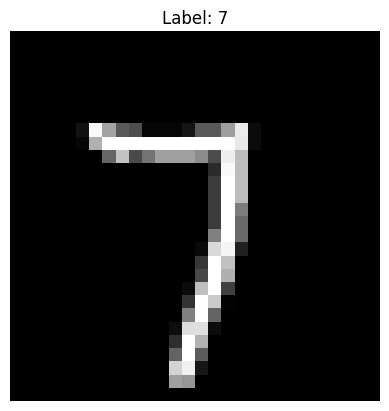

In [122]:
imv.view_random()

# Modelling

We will be using a Convolutional Neural Network for this project. If you want to know more about this model, I wrote a blog post about it here: https://rablog.vercel.app/posts/convolutional-neural-networks

This is the CNN architecture we will be using:

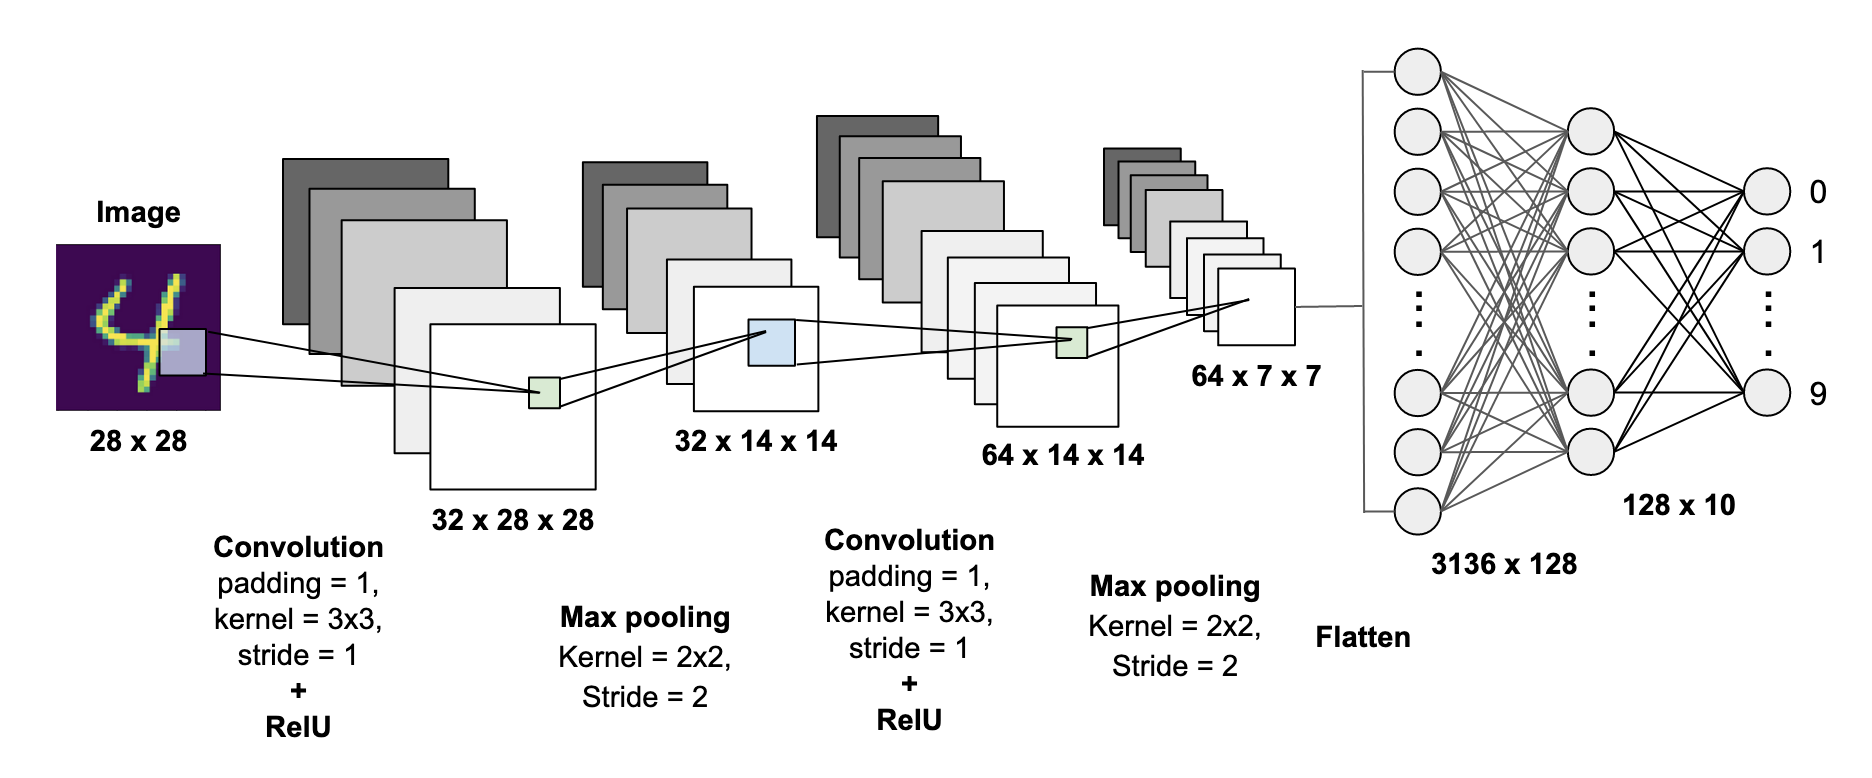

In [123]:
url = "https://media.graphassets.com/rkmYGxntR1KMUMdlFHcQ?_gl=1*1u357kw*_ga*MTYwMTM1ODUyNS4xNjczNzcwNTI3*_ga_G6FYGSYGZ4*MTY4MTAzMTIxMC4xOC4xLjE2ODEwMzEyMzEuMzkuMC4w"
response = requests.get(url)
Image.open(BytesIO(response.content))

## Data preprocessing

Let's get our data ready for training!

In [124]:
X_train = df_train.iloc[:, 1:].to_numpy()
y_train = df_train["label"].to_numpy()

In [125]:
X_train.shape, y_train.shape

((42000, 784), (42000,))

We need to convert our features into matrix format. We also need to convert our target variable into an encoded categorical matrix.

In [126]:
X_train = X_train.reshape((42000, 28, 28, 1))
y_train = LabelBinarizer().fit_transform(y_train)

In [127]:
X_train.shape, y_train.shape

((42000, 28, 28, 1), (42000, 10))

In [128]:
train_datagen = ImageDataGenerator(validation_split=0.2)
train_datagen.fit(X_train)

## Fitting

Let's build the model using the AlexNet architecture.

In [129]:
model = Sequential([
    # Layer 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    # Layer 2
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    # Flatten
    Flatten(),
    # ANN
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
])

In [130]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [131]:
epochs = 10

In [132]:
history = model.fit(
    train_datagen.flow(X_train, y_train, 
                       batch_size=32, subset='training'),
    validation_data=train_datagen.flow(X_train, y_train, 
                                       batch_size=8, subset='validation'),
    epochs=epochs
).history

Epoch 1/10
1050/1050 [==============================] - 11s 9ms/step - loss: 0.3345 - accuracy: 0.9369 - val_loss: 0.1100 - val_accuracy: 0.9670
Epoch 2/10
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0677 - accuracy: 0.9793 - val_loss: 0.0798 - val_accuracy: 0.9756
Epoch 3/10
1050/1050 [==============================] - 9s 9ms/step - loss: 0.0511 - accuracy: 0.9845 - val_loss: 0.0695 - val_accuracy: 0.9820
Epoch 4/10
1050/1050 [==============================] - 10s 10ms/step - loss: 0.0429 - accuracy: 0.9867 - val_loss: 0.0731 - val_accuracy: 0.9790
Epoch 5/10
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0371 - accuracy: 0.9887 - val_loss: 0.0758 - val_accuracy: 0.9771
Epoch 6/10
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0306 - accuracy: 0.9906 - val_loss: 0.0801 - val_accuracy: 0.9806
Epoch 7/10
1050/1050 [==============================] - 9s 8ms/step - loss: 0.0279 - accuracy: 0.9914 - val_loss: 0.0910 - val_accura

Let's graph the accuracy and loss of our models across the epochs.

In [133]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(epochs), y=history["val_accuracy"], name="Validation Accuracy"))
fig.add_trace(go.Scatter(x=np.arange(epochs), y=history["accuracy"], name="Accuracy"))
fig.update_layout(title="CNN Training Accuracy", xaxis_title="Epoch", yaxis_title="Accuracy")
fig.show()

In [134]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(epochs), y=history["val_loss"], name="Validation Loss"))
fig.add_trace(go.Scatter(x=np.arange(epochs), y=history["loss"], name="Loss"))
fig.update_layout(title="CNN Training Loss", xaxis_title="Epoch", yaxis_title="Loss")
fig.show()

## Inference

Let's first prepare the testing dataset for inference.

In [135]:
df_test.shape

(28000, 784)

In [136]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
X_test = df_test.to_numpy().reshape((28000, 28, 28, 1))

In [138]:
X_test.shape

(28000, 28, 28, 1)

Let's make our predictions!

In [139]:
predictions = np.argmax(model.predict(X_test), axis=1)

875/875 [==============================] - 2s 2ms/step


In [140]:
predictions

array([2, 0, 9, ..., 3, 9, 2])

In [141]:
predictions_df = pd.DataFrame({
    "ImageId": np.arange(28000)+1,
    "Label": predictions
})

In [142]:
predictions_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [143]:
predictions_df.to_csv("predictions.csv", index=False)